In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import time

In [2]:
image_folder = "/kaggle/input/smiles-qr250/kaggle/working/smiles_qr_codes" 
csv_file = "/kaggle/input/qm9-props/qm9_smiles_properties.csv"

In [3]:
properties_df = pd.read_csv(csv_file)

smiles_idx = properties_df.iloc[:, 1].values
properties = properties_df.iloc[:, -2].values  

properties_tensor = torch.tensor(properties, dtype=torch.float32)

image_tensors = []

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
for img_name in smiles_idx:
    img_path = os.path.join(image_folder, str(img_name) + '.png') 
    image = Image.open(img_path)
    image = transform(image)
    image_tensors.append(image)

image_tensors = torch.stack(image_tensors)

In [5]:
batch_size = 32

train_images, test_images, train_properties, test_properties = train_test_split(
    image_tensors, properties_tensor, test_size=0.15, random_state=42)

val_images, test_images, val_properties, test_properties = train_test_split(
    test_images, test_properties, test_size=0.5, random_state=42)

train_dataset = TensorDataset(train_images, train_properties)
val_dataset = TensorDataset(val_images, val_properties)
test_dataset = TensorDataset(test_images, test_properties)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model = models.resnet18(pretrained=True)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

consecutive_increase_counter = 0
max_allowed_increases = 3
prev_val_loss = float('inf')

train_losses = []
val_losses = []

epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, properties in train_loader:
        images, properties = images.to(device), properties.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        outputs = outputs.squeeze(-1)
        loss = criterion(outputs, properties)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss) 

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, properties in val_loader:
            images, properties = images.to(device), properties.to(device)

            outputs = model(images)
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, properties)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss > prev_val_loss:
        consecutive_increase_counter += 1
    else:
        consecutive_increase_counter = 0 

    prev_val_loss = avg_val_loss

    if consecutive_increase_counter >= max_allowed_increases:
        print(f"Early stopping triggered after {max_allowed_increases} consecutive increases in validation loss!")
        break

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 17.0MB/s]


Epoch [1/50], Train Loss: 7837.4432, Validation Loss: 353.0975
Epoch [2/50], Train Loss: 276.4908, Validation Loss: 262.2445
Epoch [3/50], Train Loss: 183.6694, Validation Loss: 167.9299
Epoch [4/50], Train Loss: 123.4180, Validation Loss: 156.8452
Epoch [5/50], Train Loss: 91.4257, Validation Loss: 109.8355
Epoch [6/50], Train Loss: 73.1732, Validation Loss: 100.0941
Epoch [7/50], Train Loss: 62.1662, Validation Loss: 101.6261
Epoch [8/50], Train Loss: 51.4344, Validation Loss: 77.9391
Epoch [9/50], Train Loss: 45.2972, Validation Loss: 80.6198
Epoch [10/50], Train Loss: 39.9339, Validation Loss: 82.3533
Epoch [11/50], Train Loss: 35.4404, Validation Loss: 73.4619
Epoch [12/50], Train Loss: 31.8264, Validation Loss: 75.1538
Epoch [13/50], Train Loss: 28.7116, Validation Loss: 64.2560
Epoch [14/50], Train Loss: 26.5110, Validation Loss: 62.4059
Epoch [15/50], Train Loss: 23.1358, Validation Loss: 70.2118
Epoch [16/50], Train Loss: 22.0510, Validation Loss: 55.0087
Epoch [17/50], Train 

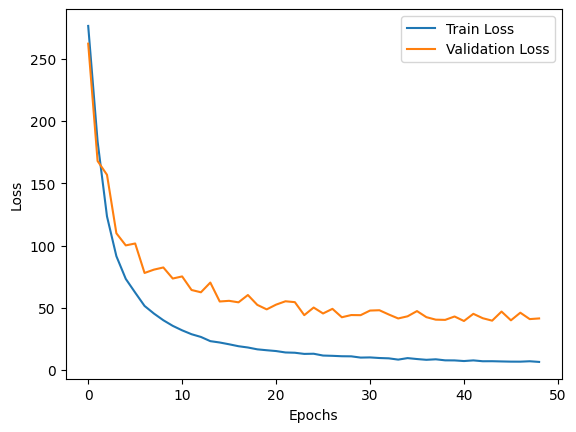

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()

actual_values = []
predicted_values = []

start_time = time.time()

with torch.no_grad():
    for images, properties in test_loader:
        images, properties = images.to(device), properties.to(device)

        outputs = model(images).squeeze(-1) 
        actual_values.extend(properties.cpu().numpy())
        predicted_values.extend(outputs.cpu().numpy())

end_time = time.time()

actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)
inference_time = (end_time - start_time) / len(test_loader)

print(f"Inference Time per 1000 samples: {inference_time*1000:.4f} seconds")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared (R²): {r2:.4f}")

Inference Time per 1000 samples: 10.5091 seconds
Mean Squared Error (MSE): 49.9385
Mean Absolute Error (MAE): 3.4024
R-Squared (R²): 0.9692


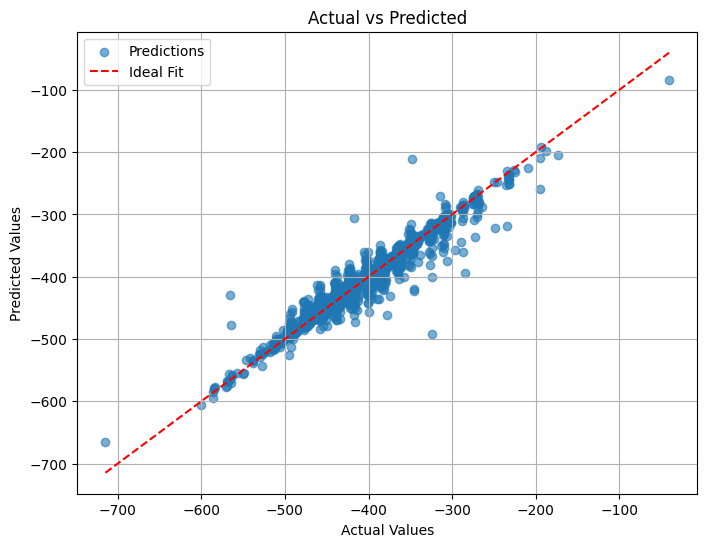

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
plt.plot(
    [min(actual_values), max(actual_values)],
    [min(actual_values), max(actual_values)],
    color="red",
    linestyle="--",
    label="Ideal Fit"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()